# BEF & CCF Prediction
This notebook presents an explainable machine learning pipeline for predicting
two drilling failure modes: **Build-up Edge Failure (BEF)** and
**Compression Chip Failure (CCF)**.

- Decision Tree Training
- Rule Extraction
- Original data is used

Software Lab 2025 Group 25

File made by:  Nien-Ying Lin (03803153)
go57vov@tum.de

Documentation made by: Nien-Ying Lin (03803153) and Eduardo Silva (03805057)

#  1) Environment & Imports

In [12]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)
from sklearn.tree import DecisionTreeClassifier, _tree
from pathlib import Path

try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False

np.random.seed(42)

## BEF/CCF Rules (All Features)

### Global Configuration

In [13]:
# Settings for model training, dataset processing, and evaluation
BEST = {
    "BEF": {"max_depth": 5,  "split_seed": 2},  # Best hyperparameters for BEF target
    "CCF": {"max_depth": 13, "split_seed": 53}, # Best hyperparameters for CCF target
}
TEST_SIZE = 0.20  # Proportion of data to use for testing
CRITERION = "gini"  # Splitting criterion for decision tree
MIN_SAMPLES_SPLIT = 2  # Minimum samples required to split a node
MIN_SAMPLES_LEAF  = 1  # Minimum samples required to be at a leaf node

### Dataset Column Alignment

In [14]:
# Function to print a formatted bar with a title
def print_bar(title):
    print("\n" + "#"*70)
    print("# " + title)
    print("#"*70 + "\n")

# Mapping of canonical column names to variant names in dataset
CANONICAL_MAP = {
    "Cutting_speed": ["Cutting_speed", "Cutting speed vc [m/min]"],
    "Spindle_speed": ["Spindle_speed", "Spindle speed n [1/min]"],
    "Feed_f": ["Feed_f", "Feed f [mm/rev]"],
    "Feed_rate": ["Feed_rate", "Feed rate vf [mm/min]"],
    "Power_Pc": ["Power_Pc", "Power Pc [kW]"],
    "Cooling": ["Cooling", "Cooling [%]"],
    "Material": ["Material"],
    "Drill_Bit_Type": ["Drill_Bit_Type", "Drill Bit Type"],
    "Process_Time": ["Process_Time", "Process Time [sec]"],
    "BEF": ["BEF"], "CCF": ["CCF"], "FWF": ["FWF"], "WDF": ["WDF"]
}

# Safely retrieves a column from the DataFrame given a list of possible column names
def _safe_get(df, variants):
    for c in variants:
        if c in df.columns:
            return df[c]
    raise KeyError(f"Missing columns: {variants}")


### Feature Preparation

Category Reference

| Feature         | Category | Code |
|----------------|----------|---------------|
| Material       | K        | 0             |
| Material       | N        | 1             |
| Material       | P        | 2             |
| Drill_Bit_Type | H        | 0             |
| Drill_Bit_Type | N        | 1             |
| Drill_Bit_Type | W        | 2             |

In [15]:

# Function to load the dataset and standardize column names
def load_dataset(path):
    print("\nLoading dataset from:", path)
    df0 = pd.read_csv(path)  # Read CSV file into DataFrame

    df = pd.DataFrame()  # New DataFrame to store canonicalized columns
    for canon, variants in CANONICAL_MAP.items():
        try:
            df[canon] = _safe_get(df0, variants)  # Standardize column names
        except KeyError:
            pass

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Print failure distribution if failure columns exist
    if all(c in df.columns for c in ["BEF","CCF","FWF","WDF"]):
        print("\nFailure distribution:")
        for t in ["BEF","CCF","FWF","WDF"]:
            n = int(df[t].sum())
            print(f"  {t}: {n} ({n/len(df)*100:.2f}%)")

    return df

# Function to prepare features and target for model training
def prepare_features(df, target):
    # Base columns to use for training
    base_cols = ["Cutting_speed", "Spindle_speed", "Feed_f", "Feed_rate",
                 "Power_Pc", "Cooling", "Process_Time", "Material", "Drill_Bit_Type"]
    use_cols = [c for c in base_cols if c in df.columns]  # Select columns present in DataFrame

    X = df[use_cols].copy()  # Features (independent variables)
    y = df[target].astype(int).copy()  # Target (dependent variable)

    # Handle Cooling as a discrete ordinal variable if appropriate
    if "Cooling" in X.columns:
        raw = pd.to_numeric(X["Cooling"], errors="coerce")  # Convert to numeric values
        uniq = np.sort(raw.dropna().unique())  # Get unique values of Cooling

        # Check if Cooling behaves discretely
        def is_near_discrete(val):
            return any(abs(val - t) <= 2 for t in [0, 25, 50, 100])

        frac_discrete = raw.apply(is_near_discrete).sum() / max(len(raw.dropna()), 1)

        if frac_discrete > 0.9 and len(uniq) <= 8:
            # Treat Cooling as ordinal (0/25/50/100)
            def nearest_level(val):
                return min([0, 25, 50, 100], key=lambda x: abs(x - val))
            ordinal_map = {0: 0, 25: 1, 50: 2, 100: 3}
            X["Cooling_ord"] = raw.apply(nearest_level).map(ordinal_map).astype(int)
            X["Cooling"] = raw.fillna(0)  # Fill missing values
            print(f"  Cooling detected as discrete (0/25/50/100); added Cooling_ord")
        else:
            X["Cooling"] = raw.fillna(raw.median())  # Fill missing with median if not discrete

    # Handle numeric columns by converting to numeric and filling missing values
    numeric_cols = ["Cutting_speed", "Spindle_speed", "Feed_f", "Feed_rate",
                    "Power_Pc", "Cooling", "Process_Time"]
    for c in numeric_cols:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce")
            X[c] = X[c].fillna(X[c].median())  # Fill missing values with median

    # Encode categorical columns as numeric codes
    for c in ["Material", "Drill_Bit_Type"]:
        if c in X.columns:
            X[c + "_enc"] = X[c].astype("category").cat.codes

    # Select final columns to use for model training
    keep = [c for c in ["Cutting_speed", "Spindle_speed", "Feed_f", "Feed_rate",
                        "Power_Pc", "Cooling", "Process_Time", "Cooling_ord",
                        "Material_enc", "Drill_Bit_Type_enc"] if c in X.columns]
    return X[keep].copy(), y, keep


### Rule Extraction from Decision Trees

After training, the decision tree structure is traversed to extract
human-readable rules.

Each rule corresponds to a leaf node predicting failure and includes:
- A set of feature-based conditions
- The number of samples covered by the rule
- The confidence (leaf purity)

In [16]:

# Function to extract rules from a trained decision tree model
def export_tree_rules(dt_model, feature_names, target, X_train, y_train):
    tree = dt_model.tree_  # Decision tree structure
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree.feature
    ]
    leaf_samples = dt_model.apply(X_train)  # Get leaf node assignments

    rules = []  # List to store extracted rules

    # Recursive function to traverse the decision tree and extract rules
    def recurse(node, conditions):
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree.threshold[node]
            recurse(tree.children_left[node],  conditions + [f"{name} <= {threshold:.2f}"])
            recurse(tree.children_right[node], conditions + [f"{name} > {threshold:.2f}"])
        else:
            mask = (leaf_samples == node)
            n_samples = int(mask.sum())
            if n_samples > 0:
                y_node = y_train[mask]
                n0 = int((y_node == 0).sum())  # Number of OK samples
                n1 = int((y_node == 1).sum())  # Number of FAILURE samples
            else:
                n0 = n1 = 0
            pred_class = 1 if n1 > n0 else 0  # Majority class as prediction
            confidence = (max(n0, n1) / n_samples) if n_samples > 0 else 0.0
            rules.append({
                "conditions": conditions,
                "prediction": "FAILURE" if pred_class == 1 else "OK",
                "confidence": confidence,
                "samples": n_samples,
                "class_distribution": [n0, n1]
            })

    recurse(0, [])  # Start tree traversal from root

    # Print and return discovered rules
    print(f"\n{'='*70}")
    print(f"DISCOVERED RULES FOR {target} FAILURE")
    print(f"{'='*70}\n")

    failure_rules = [r for r in rules if r["prediction"] == "FAILURE"]
    if not failure_rules:
        print("No failure rules found.")
        return rules
    
    # Sort failure rules by number of failure samples
    failure_rules_sorted = sorted(failure_rules, key=lambda x: x['class_distribution'][1], reverse=True)
    total_failure_samples = sum(r['class_distribution'][1] for r in failure_rules_sorted)
    print(f"Total failure rules: {len(failure_rules_sorted)}")
    print(f"Total failure samples covered: {total_failure_samples}\n")

    for i, rule in enumerate(failure_rules_sorted, 1):
        n_ok, n_fail = rule['class_distribution']
        coverage_pct = (n_fail / max(total_failure_samples, 1)) * 100
        print(f"Rule {i}: FAILURE")
        print(f"  Coverage: {n_fail} fail samples ({coverage_pct:.1f}% of failures)")
        print(f"  Leaf node: {rule['samples']} total samples (OK: {n_ok}, FAIL: {n_fail})")
        print(f"  Confidence: {rule['confidence']:.3f}")
        print(f"  Conditions:")
        for cond in rule["conditions"]:
            print(f"    • {cond}")
        print()
    return rules



### Threshold Selection

In [17]:
# Function to find the best threshold for F1 score optimization
def find_best_threshold_f1(y_true, y_prob):
    p, r, t = precision_recall_curve(y_true, y_prob)  # Precision, recall, and thresholds
    f1 = 2 * p * r / (p + r + 1e-12)  # Calculate F1 score
    idx = np.nanargmax(f1)  # Find index of max F1 score
    thr = t[min(idx, len(t)-1)] if len(t) > 0 else 0.5  # Best threshold
    return float(thr), float(p[idx]), float(r[idx]), float(f1[idx])

# Function to evaluate performance at a specific threshold
def eval_at_threshold(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)  # Convert probabilities to binary predictions
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return p, r, f, cm 

### Visualization

- Confusion Matrix
- Feature Importance
- Error Distribution

In [18]:
# ---------------- Plots ----------------
def plot_confusion_matrix_single(cm, title):
    plt.figure(figsize=(4.5, 4))
    if HAS_SEABORN:
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    else:
        plt.matshow(cm, cmap="Blues")
        for (i, j), val in np.ndenumerate(cm):
            plt.text(j, i, f"{val}", ha='center', va='center')
        plt.gca().set_xticks(range(2)); plt.gca().set_yticks(range(2))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_feature_importance(model, X, title):
    imp = getattr(model, "feature_importances_", None)
    if imp is None:
        return
    idx = np.argsort(imp)[::-1]
    plt.figure(figsize=(9, 5.5))
    plt.bar(range(len(imp)), imp[idx], align='center')
    plt.xticks(range(len(imp)), np.array(X.columns)[idx], rotation=45, ha='right')
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_error_hist(y_true, y_prob, title):
    errors = y_true - y_prob
    plt.figure(figsize=(7, 5))
    plt.hist(errors, bins=20, edgecolor="black")
    plt.xlabel("Error = y_true - predicted_prob")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()

### Model Results

- Train–test split with a fixed random seed and depth
- Rule extraction


Loading dataset from: /home/myuser/TUM/sl-siemens/LLMs-Drill-Wear/Dataset/XAI_Drilling_Dataset.csv
Dataset shape: (20000, 13)
Columns: ['Cutting_speed', 'Spindle_speed', 'Feed_f', 'Feed_rate', 'Power_Pc', 'Cooling', 'Material', 'Drill_Bit_Type', 'Process_Time', 'BEF', 'CCF', 'FWF', 'WDF']

Failure distribution:
  BEF: 215 (1.07%)
  CCF: 344 (1.72%)
  FWF: 278 (1.39%)
  WDF: 300 (1.50%)

######################################################################
# BEF: depth=5, split_seed=2
######################################################################

Features (9): ['Cutting_speed', 'Spindle_speed', 'Feed_f', 'Feed_rate', 'Power_Pc', 'Cooling', 'Process_Time', 'Material_enc', 'Drill_Bit_Type_enc']
Failure rate: 1.07%
Train: 16000, Test: 4000

DISCOVERED RULES FOR BEF FAILURE

Total failure rules: 4
Total failure samples covered: 164

Rule 1: FAILURE
  Coverage: 68 fail samples (41.5% of failures)
  Leaf node: 68 total samples (OK: 0, FAIL: 68)
  Confidence: 1.000
  Conditions:
   

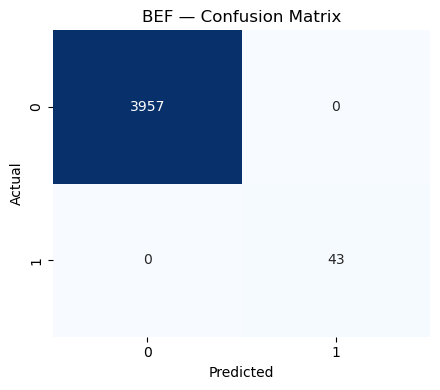

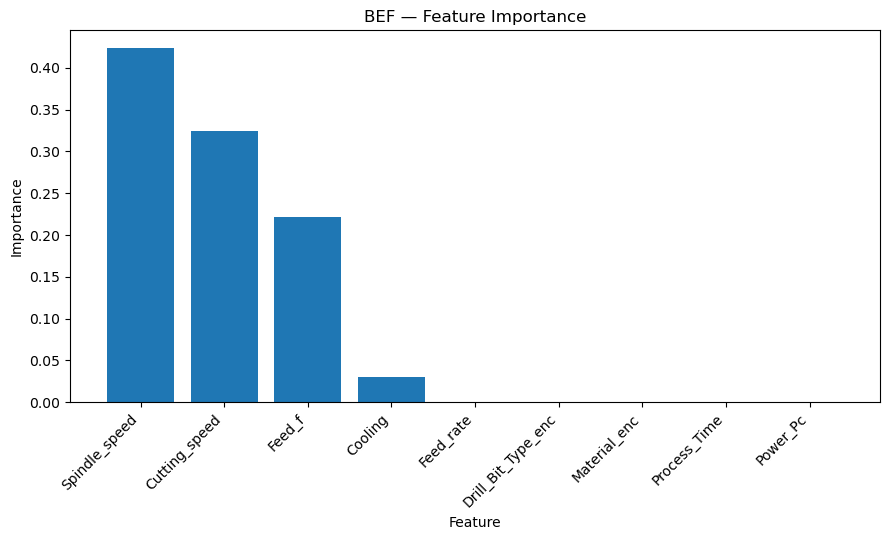

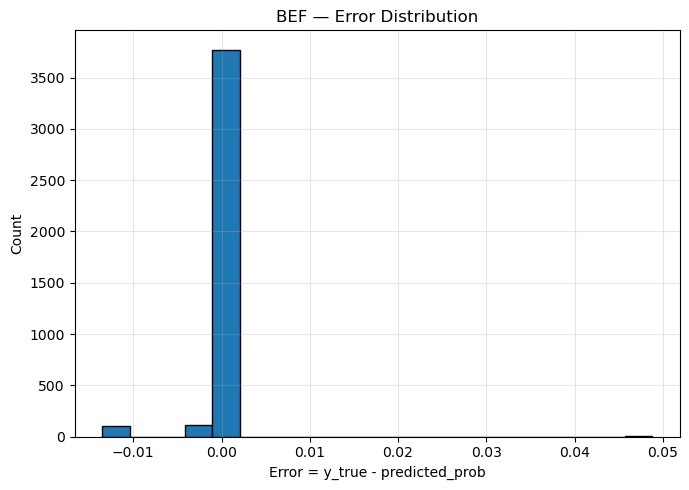


######################################################################
# CCF: depth=13, split_seed=53
######################################################################

Features (9): ['Cutting_speed', 'Spindle_speed', 'Feed_f', 'Feed_rate', 'Power_Pc', 'Cooling', 'Process_Time', 'Material_enc', 'Drill_Bit_Type_enc']
Failure rate: 1.72%
Train: 16000, Test: 4000

DISCOVERED RULES FOR CCF FAILURE

Total failure rules: 23
Total failure samples covered: 275

Rule 1: FAILURE
  Coverage: 171 fail samples (62.2% of failures)
  Leaf node: 171 total samples (OK: 0, FAIL: 171)
  Confidence: 1.000
  Conditions:
    • Cooling <= 37.50
    • Feed_rate > 126.50
    • Power_Pc > 63.52
    • Power_Pc > 64.58

Rule 2: FAILURE
  Coverage: 29 fail samples (10.5% of failures)
  Leaf node: 29 total samples (OK: 0, FAIL: 29)
  Confidence: 1.000
  Conditions:
    • Cooling > 37.50
    • Feed_rate > 206.50
    • Drill_Bit_Type_enc <= 1.50

Rule 3: FAILURE
  Coverage: 19 fail samples (6.9% of failures)
  

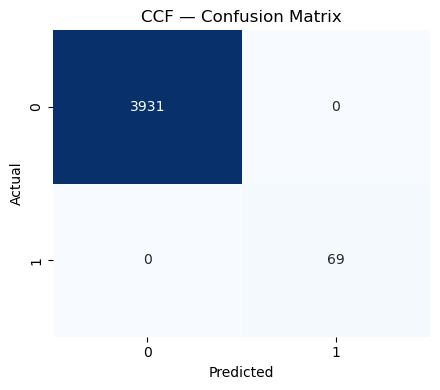

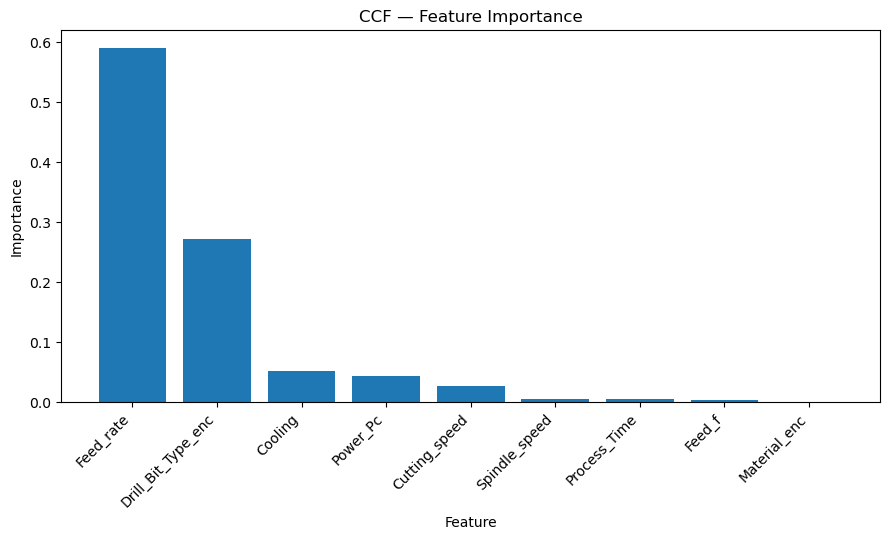

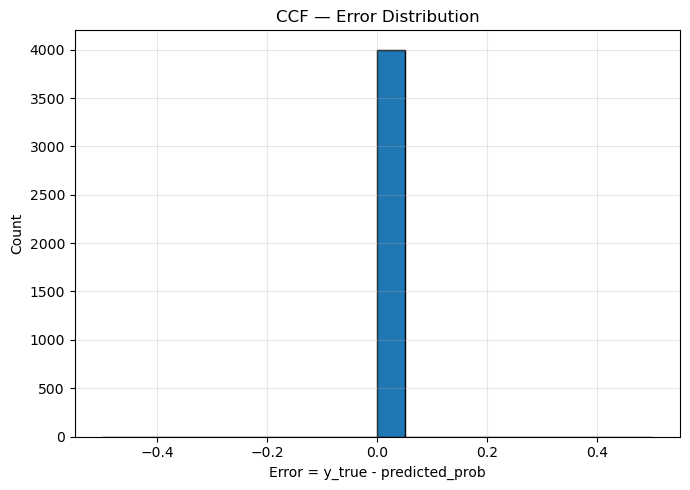

In [19]:
# Function to train a model for a single target and evaluate performance
def run_single_target(df, target, max_depth, split_seed):
    print_bar(f"{target}: depth={max_depth}, split_seed={split_seed}")

    X, y, features = prepare_features(df, target)  # Prepare features and target
    print(f"Features ({len(features)}): {features}")
    print(f"Failure rate: {y.mean()*100:.2f}%")

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=split_seed
    )  # Split data into training and testing sets
    print(f"Train: {len(X_tr)}, Test: {len(X_te)}")

    # Train decision tree classifier
    clf = DecisionTreeClassifier(
        criterion=CRITERION,
        max_depth=max_depth,
        min_samples_split=MIN_SAMPLES_SPLIT,
        min_samples_leaf=MIN_SAMPLES_LEAF,
        random_state=0
    )
    clf.fit(X_tr, y_tr)  # Train model

    # Extract & print rules from decision tree
    _ = export_tree_rules(clf, X_tr.columns.tolist(), target, X_tr.values, y_tr.values)

    # Evaluate on TEST set using F1-optimal threshold over probabilities
    y_prob_te = clf.predict_proba(X_te)[:, 1]  # Get probability predictions for test set
    thr, p_te, r_te, f1_te = find_best_threshold_f1(y_te, y_prob_te)  # Find best threshold
    y_pred_te = (y_prob_te >= thr).astype(int)  # Apply threshold to get predictions
    cm_te = confusion_matrix(y_te, y_pred_te)  # Confusion matrix

    # Print test performance results
    print(f"\n{'='*70}")
    print(f"{target} — TEST PERFORMANCE (at F1-optimal threshold)")
    print(f"{'='*70}")
    print(f"Threshold : {thr:.3f}")
    print(f"Precision : {p_te:.3f}")
    print(f"Recall    : {r_te:.3f}")
    print(f"F1        : {f1_te:.3f}")

    plot_confusion_matrix_single(cm_te, f"{target} — Confusion Matrix")
    plot_feature_importance(clf, X_tr, f"{target} — Feature Importance")
    plot_error_hist(y_te.values, y_prob_te, f"{target} — Error Distribution")

# Main function to load data and run models for BEF and CCF targets
def main(data_path):
    df = load_dataset(data_path)  # Load dataset
    run_single_target(df, "BEF", BEST["BEF"]["max_depth"], BEST["BEF"]["split_seed"])  # Run for BEF
    run_single_target(df, "CCF", BEST["CCF"]["max_depth"], BEST["CCF"]["split_seed"])  # Run for CCF

# Entry point of the script
if __name__ == "__main__":
    BASE_DIR = Path.cwd()
    # get dataset file path
    DATA_PATH = BASE_DIR.parent.parent / "Dataset/XAI_Drilling_Dataset.csv"
    main(DATA_PATH)  # Run the main function with the dataset


## CCF Rules (Selected Features)

We tried using a selected subset of features to reduce model complexity, but this strategy proved to be ineffective.


Loading dataset from: /home/myuser/TUM/sl-siemens/LLMs-Drill-Wear/Dataset/XAI_Drilling_Dataset.csv
Dataset shape: (20000, 13)
Columns: ['Cutting_speed', 'Spindle_speed', 'Feed_f', 'Feed_rate', 'Power_Pc', 'Cooling', 'Material', 'Drill_Bit_Type', 'Process_Time', 'BEF', 'CCF', 'FWF', 'WDF']

Failure distribution:
  BEF: 215 (1.07%)
  CCF: 344 (1.72%)
  FWF: 278 (1.39%)
  WDF: 300 (1.50%)

Feature set used: ['Cooling', 'Feed_rate', 'Material_enc', 'Drill_Bit_Type_enc']

--- Extracting Rules for CCF ---

DISCOVERED RULES FOR CCF FAILURE

Total failure rules: 13
Total failure samples covered: 256

Rule 1: FAILURE
  Coverage: 134 fail samples (52.3% of failures)
  Leaf node: 134 total samples (OK: 0, FAIL: 134)
  Confidence: 1.000
  Conditions:
    • Cooling <= 37.50
    • Feed_rate > 124.50
    • Feed_rate > 128.50
    • Feed_rate > 130.50

Rule 2: FAILURE
  Coverage: 29 fail samples (11.3% of failures)
  Leaf node: 29 total samples (OK: 0, FAIL: 29)
  Confidence: 1.000
  Conditions:
    •

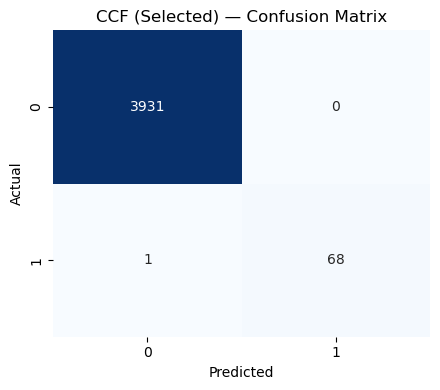

In [20]:
# Settings
CCF_TARGET = "CCF"
CCF_MAX_DEPTH = 7
CCF_SPLIT_SEED = 51
# Explicitly define feature types for cleaner processing
CCF_NUM_VARS = ["Cooling", "Feed_rate"]
CCF_CAT_VARS = ["Material", "Drill_Bit_Type"]

# Simplified Feature Preparation Function
def prepare_features_ccf_selected(df, target):
    """
    Simplified: Converts numeric directly and encodes categorical features.
    """
    X = df.copy()
    y = df[target].astype(int).copy()

    # Numeric Features
    for c in CCF_NUM_VARS:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce")
            X[c] = X[c].fillna(X[c].median())

    # Categorical Features
    encoded_cat_cols = []
    for c in CCF_CAT_VARS:
        if c in X.columns:
            new_col_name = c + "_enc"
            X[new_col_name] = X[c].astype("category").cat.codes
            encoded_cat_cols.append(new_col_name)
            
    final_features = [c for c in CCF_NUM_VARS if c in X.columns] + encoded_cat_cols
    
    return X[final_features], y, final_features

# Execution Flow
# Load Dataset
BASE_DIR = Path.cwd()
# get dataset file path
DATA_PATH = BASE_DIR.parent.parent / "Dataset/XAI_Drilling_Dataset.csv"
df_ccf_raw = load_dataset(DATA_PATH)

# Prepare Features
X_ccf, y_ccf, feats_ccf = prepare_features_ccf_selected(df_ccf_raw, CCF_TARGET)
print(f"\nFeature set used: {feats_ccf}")

# Split Data
X_tr_ccf, X_te_ccf, y_tr_ccf, y_te_ccf = train_test_split(
    X_ccf, y_ccf, test_size=0.20, stratify=y_ccf, random_state=CCF_SPLIT_SEED
)

# Train Model
clf_ccf = DecisionTreeClassifier(
    max_depth=CCF_MAX_DEPTH,
    criterion="gini",
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
clf_ccf.fit(X_tr_ccf, y_tr_ccf)

# Rule Extraction
print(f"\n--- Extracting Rules for {CCF_TARGET} ---")
_ = export_tree_rules(clf_ccf, X_tr_ccf.columns.tolist(), CCF_TARGET, X_tr_ccf.values, y_tr_ccf.values)

# Test Set Validation
y_prob_ccf = clf_ccf.predict_proba(X_te_ccf)[:, 1]
thr_ccf, p_ccf, r_ccf, f1_ccf = find_best_threshold_f1(y_te_ccf, y_prob_ccf)
y_pred_ccf = (y_prob_ccf >= thr_ccf).astype(int)
cm_ccf = confusion_matrix(y_te_ccf, y_pred_ccf)

print(f"\n{'='*70}")
print(f"CCF (Selected Features) — TEST RESULTS")
print(f"{'='*70}")
print(f"Threshold : {thr_ccf:.3f}")
print(f"Precision : {p_ccf:.3f}")
print(f"Recall    : {r_ccf:.3f}")
print(f"F1        : {f1_ccf:.3f}")

# Plotting
plot_confusion_matrix_single(cm_ccf, f"CCF (Selected) — Confusion Matrix")